In [1]:
from pathlib import Path

DATASET_PATH = Path("../dataset/")
TRAIN_DATA_PATH = DATASET_PATH / "train.csv"
TEST_DATA_PATH = DATASET_PATH / "test.csv"
SUBMIT_DATA_PATH = DATASET_PATH / "sample_submit.csv"

In [2]:
import polars as pl
import polars.selectors as cs
import numpy as np

train_df = pl.scan_csv(TRAIN_DATA_PATH)
test_df = pl.scan_csv(TEST_DATA_PATH).with_columns(pl.lit(None).alias("blueWins"))
all_df = pl.concat([train_df, test_df]).collect()

In [3]:
%%time
all_df.describe()

CPU times: user 2.83 ms, sys: 5.47 ms, total: 8.3 ms
Wall time: 2.16 ms


describe,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,8000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0
"""mean""",4999.5,0.5151,6.0654,5.9153,5.9401,0.5396,0.3584,17158.873,17987.413,0.49175
"""std""",2886.89568,0.499797,2.631808,2.649232,3.207638,0.626954,0.479554,1824.773215,771.583455,0.499963
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,13475.0,16650.0,0.0
"""25%""",2500.0,0.0,4.0,4.0,4.0,0.0,0.0,16544.0,17256.0,0.0
"""50%""",5000.0,1.0,6.0,6.0,6.0,0.0,0.0,17409.0,18021.0,0.0
"""75%""",7499.0,1.0,8.0,8.0,8.0,1.0,1.0,18274.0,18472.0,1.0
"""max""",9999.0,1.0,14.0,14.0,17.0,2.0,1.0,20619.0,20101.0,1.0


In [4]:
all_df = (
    all_df.lazy()
    .with_columns(
        (pl.col("blueEliteMonsters") - pl.col("blueDragons")).alias("blueHerald"),
        pl.col(["blueTotalExperience", "blueTotalGold"]).cast(pl.Float64),
    )
    .with_columns(
        pl.when(pl.all().is_infinite()).then(9999).otherwise(pl.all()).name.keep()
    )
    .drop(cs.by_name(["blueEliteMonsters", "blueAssists"]))
    # .filter(pl.col("blueHerald") >= 0)
    .collect()
)

train_df = all_df.filter(pl.col("blueWins").is_not_null())
test_df = all_df.filter(pl.col("blueWins").is_null())

In [5]:
all_df.describe()

describe,gameId,blueFirstBlood,blueKills,blueDeaths,blueDragons,blueTotalGold,blueTotalExperience,blueWins,blueHerald
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,8000.0,10000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0,0.0
"""mean""",4999.5,0.5151,6.0654,5.9153,0.3584,17158.873,17987.413,0.49175,0.1812
"""std""",2886.89568,0.499797,2.631808,2.649232,0.479554,1824.773215,771.583455,0.499963,0.389078
"""min""",0.0,0.0,0.0,0.0,0.0,13475.0,16650.0,0.0,-1.0
"""25%""",2500.0,0.0,4.0,4.0,0.0,16544.0,17256.0,0.0,0.0
"""50%""",5000.0,1.0,6.0,6.0,0.0,17409.0,18021.0,0.0,0.0
"""75%""",7499.0,1.0,8.0,8.0,1.0,18274.0,18472.0,1.0,0.0
"""max""",9999.0,1.0,14.0,14.0,1.0,20619.0,20101.0,1.0,2.0


In [6]:
all_df.group_by(pl.col("blueWins")).agg(
    pl.exclude("gameId").mean().name.suffix("_mean"),
    # pl.exclude("gameId").median().name.suffix("_median"),
)

blueWins,blueFirstBlood_mean,blueKills_mean,blueDeaths_mean,blueDragons_mean,blueTotalGold_mean,blueTotalExperience_mean,blueHerald_mean
i64,f64,f64,f64,f64,f64,f64,f64
0,0.401623,5.158633,6.541564,0.239302,17081.556567,17734.218396,0.130349
1,0.628114,6.930097,5.284698,0.480935,17229.011947,18241.174377,0.232334
null,0.5235,6.208,5.8825,0.3595,17178.094,18003.009,0.184


In [7]:
categorical = ["blueWins", "blueFirstBlood", "blueHerald", "blueDragons"]
numeric_cols = ["blueKills", "blueDeaths", "blueTotalGold", "blueTotalExperience"]

tmp = train_df.with_columns(pl.col(categorical).cast(pl.String))

tmp2 = all_df.clone()

import xfeat

r2 = xfeat.ConcatCombination(input_cols=categorical, r=2, drop_origin=2).fit_transform(
    tmp.to_pandas()
)
r3 = xfeat.ConcatCombination(input_cols=categorical, r=3, drop_origin=2).fit_transform(
    tmp.to_pandas()
)

tmp = pl.concat([tmp, pl.from_pandas(r2), pl.from_pandas(r3)], how="horizontal")


for cat_col in tmp.select(cs.string()).columns:
    for num_col in numeric_cols:
        a = tmp.group_by(pl.col(cat_col)).agg(
            [
                pl.col(num_col).max().alias(f"{num_col}_max__{cat_col}"),
                pl.col(num_col).min().alias(f"{num_col}_min__{cat_col}"),
                pl.col(num_col).mean().alias(f"{num_col}_mean__{cat_col}"),
                pl.col(num_col).median().alias(f"{num_col}_median__{cat_col}"),
                pl.col(num_col).quantile(0.25).alias(f"{num_col}_q25__{cat_col}"),
                pl.col(num_col).quantile(0.75).alias(f"{num_col}_q75__{cat_col}"),
                pl.col(num_col).quantile(0.33).alias(f"{num_col}_q33__{cat_col}"),
                pl.col(num_col).quantile(0.66).alias(f"{num_col}_q66__{cat_col}"),
                pl.col(num_col).quantile(0.2).alias(f"{num_col}_q20__{cat_col}"),
                pl.col(num_col).quantile(0.4).alias(f"{num_col}_q40__{cat_col}"),
                pl.col(num_col).quantile(0.6).alias(f"{num_col}_q60__{cat_col}"),
                pl.col(num_col).quantile(0.8).alias(f"{num_col}_q80__{cat_col}"),
                pl.col(num_col).std().alias(f"{num_col}_std__{cat_col}"),
            ]
        )
        for row in a.iter_rows():
            cat = row[0]
            for col, val in zip(a.columns[1:], row[1:]):
                tmp2 = tmp2.with_columns(pl.lit(val).alias(f"{col}_{cat}"))
tmp2

gameId,blueFirstBlood,blueKills,blueDeaths,blueDragons,blueTotalGold,blueTotalExperience,blueWins,blueHerald,blueKills_max__blueFirstBlood_0,blueKills_min__blueFirstBlood_0,blueKills_mean__blueFirstBlood_0,blueKills_median__blueFirstBlood_0,blueKills_q25__blueFirstBlood_0,blueKills_q75__blueFirstBlood_0,blueKills_q33__blueFirstBlood_0,blueKills_q66__blueFirstBlood_0,blueKills_q20__blueFirstBlood_0,blueKills_q40__blueFirstBlood_0,blueKills_q60__blueFirstBlood_0,blueKills_q80__blueFirstBlood_0,blueKills_std__blueFirstBlood_0,blueKills_max__blueFirstBlood_1,blueKills_min__blueFirstBlood_1,blueKills_mean__blueFirstBlood_1,blueKills_median__blueFirstBlood_1,blueKills_q25__blueFirstBlood_1,blueKills_q75__blueFirstBlood_1,blueKills_q33__blueFirstBlood_1,blueKills_q66__blueFirstBlood_1,blueKills_q20__blueFirstBlood_1,blueKills_q40__blueFirstBlood_1,blueKills_q60__blueFirstBlood_1,blueKills_q80__blueFirstBlood_1,blueKills_std__blueFirstBlood_1,blueDeaths_max__blueFirstBlood_0,blueDeaths_min__blueFirstBlood_0,…,blueTotalExperience_mean__blueFirstBloodblueHeraldblueDragons_combi_120,blueTotalExperience_median__blueFirstBloodblueHeraldblueDragons_combi_120,blueTotalExperience_q25__blueFirstBloodblueHeraldblueDragons_combi_120,blueTotalExperience_q75__blueFirstBloodblueHeraldblueDragons_combi_120,blueTotalExperience_q33__blueFirstBloodblueHeraldblueDragons_combi_120,blueTotalExperience_q66__blueFirstBloodblueHeraldblueDragons_combi_120,blueTotalExperience_q20__blueFirstBloodblueHeraldblueDragons_combi_120,blueTotalExperience_q40__blueFirstBloodblueHeraldblueDragons_combi_120,blueTotalExperience_q60__blueFirstBloodblueHeraldblueDragons_combi_120,blueTotalExperience_q80__blueFirstBloodblueHeraldblueDragons_combi_120,blueTotalExperience_std__blueFirstBloodblueHeraldblueDragons_combi_120,blueTotalExperience_max__blueFirstBloodblueHeraldblueDragons_combi_011,blueTotalExperience_min__blueFirstBloodblueHeraldblueDragons_combi_011,blueTotalExperience_mean__blueFirstBloodblueHeraldblueDragons_combi_011,blueTotalExperience_median__blueFirstBloodblueHeraldblueDragons_combi_011,blueTotalExperience_q25__blueFirstBloodblueHeraldblueDragons_combi_011,blueTotalExperience_q75__blueFirstBloodblueHeraldblueDragons_combi_011,blueTotalExperience_q33__blueFirstBloodblueHeraldblueDragons_combi_011,blueTotalExperience_q66__blueFirstBloodblueHeraldblueDragons_combi_011,blueTotalExperience_q20__blueFirstBloodblueHeraldblueDragons_combi_011,blueTotalExperience_q40__blueFirstBloodblueHeraldblueDragons_combi_011,blueTotalExperience_q60__blueFirstBloodblueHeraldblueDragons_combi_011,blueTotalExperience_q80__blueFirstBloodblueHeraldblueDragons_combi_011,blueTotalExperience_std__blueFirstBloodblueHeraldblueDragons_combi_011,blueTotalExperience_max__blueFirstBloodblueHeraldblueDragons_combi_020,blueTotalExperience_min__blueFirstBloodblueHeraldblueDragons_combi_020,blueTotalExperience_mean__blueFirstBloodblueHeraldblueDragons_combi_020,blueTotalExperience_median__blueFirstBloodblueHeraldblueDragons_combi_020,blueTotalExperience_q25__blueFirstBloodblueHeraldblueDragons_combi_020,blueTotalExperience_q75__blueFirstBloodblueHeraldblueDragons_combi_020,blueTotalExperience_q33__blueFirstBloodblueHeraldblueDragons_combi_020,blueTotalExperience_q66__blueFirstBloodblueHeraldblueDragons_combi_020,blueTotalExperience_q20__blueFirstBloodblueHeraldblueDragons_combi_020,blueTotalExperience_q40__blueFirstBloodblueHeraldblueDragons_combi_020,blueTotalExperience_q60__blueFirstBloodblueHeraldblueDragons_combi_020,blueTotalExperience_q80__blueFirstBloodblueHeraldblueDragons_combi_020,blueTotalExperience_std__blueFirstBloodblueHeraldblueDragons_combi_020
i64,i64,i64,i64,i64,f64,f64,i64,i64,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,i32,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,null,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0,5,8,0,14536.0,17256.0,0,0,12,0,5.26617,5.

In [8]:
wins_df = train_df.filter(pl.col("blueWins") == 1)
lose_df = train_df.filter(pl.col("blueWins") == 1)

win_kill_mean = wins_df["blueKills"].mean()
lose_kill_mean = lose_df["blueKills"].mean()
win_death_mean = wins_df["blueDeaths"].mean()
lose_death_mean = lose_df["blueDeaths"].mean()
win_experience_mean = wins_df["blueTotalExperience"].mean()
lose_experience_mean = lose_df["blueTotalExperience"].mean()

win_kill_median = wins_df["blueKills"].median()
lose_kill_median = lose_df["blueKills"].median()
win_death_median = wins_df["blueDeaths"].median()
lose_death_median = lose_df["blueDeaths"].median()
win_experience_median = wins_df["blueTotalExperience"].median()
lose_experience_median = lose_df["blueTotalExperience"].median()

win_kill_q25 = wins_df["blueKills"].quantile(0.25)
lose_kill_q25 = lose_df["blueKills"].quantile(0.25)
win_death_q25 = wins_df["blueDeaths"].quantile(0.25)
lose_death_q25 = lose_df["blueDeaths"].quantile(0.25)
win_experience_q25 = wins_df["blueTotalExperience"].quantile(0.25)
lose_experience_q25 = lose_df["blueTotalExperience"].quantile(0.25)

win_kill_q75 = wins_df["blueKills"].quantile(0.75)
lose_kill_q75 = lose_df["blueKills"].quantile(0.75)
win_death_q75 = wins_df["blueDeaths"].quantile(0.75)
lose_death_q75 = lose_df["blueDeaths"].quantile(0.75)
win_experience_q75 = wins_df["blueTotalExperience"].quantile(0.75)
lose_experience_q75 = lose_df["blueTotalExperience"].quantile(0.75)

win_kill_q33 = wins_df["blueKills"].quantile(0.33)
lose_kill_q33 = lose_df["blueKills"].quantile(0.33)
win_death_q33 = wins_df["blueDeaths"].quantile(0.33)
lose_death_q33 = lose_df["blueDeaths"].quantile(0.33)
win_experience_q33 = wins_df["blueTotalExperience"].quantile(0.33)
lose_experience_q33 = lose_df["blueTotalExperience"].quantile(0.33)

win_kill_q66 = wins_df["blueKills"].quantile(0.66)
lose_kill_q66 = lose_df["blueKills"].quantile(0.66)
win_death_q66 = wins_df["blueDeaths"].quantile(0.66)
lose_death_q66 = lose_df["blueDeaths"].quantile(0.66)
win_experience_q66 = wins_df["blueTotalExperience"].quantile(0.66)
lose_experience_q66 = lose_df["blueTotalExperience"].quantile(0.66)

win_kill_q20 = wins_df["blueKills"].quantile(0.20)
lose_kill_q20 = lose_df["blueKills"].quantile(0.20)
win_death_q20 = wins_df["blueDeaths"].quantile(0.20)
lose_death_q20 = lose_df["blueDeaths"].quantile(0.20)
win_experience_q20 = wins_df["blueTotalExperience"].quantile(0.20)
lose_experience_q20 = lose_df["blueTotalExperience"].quantile(0.20)

win_kill_q40 = wins_df["blueKills"].quantile(0.40)
lose_kill_q40 = lose_df["blueKills"].quantile(0.40)
win_death_q40 = wins_df["blueDeaths"].quantile(0.40)
lose_death_q40 = lose_df["blueDeaths"].quantile(0.40)
win_experience_q40 = wins_df["blueTotalExperience"].quantile(0.40)
lose_experience_q40 = lose_df["blueTotalExperience"].quantile(0.40)

win_kill_q60 = wins_df["blueKills"].quantile(0.60)
lose_kill_q60 = lose_df["blueKills"].quantile(0.60)
win_death_q60 = wins_df["blueDeaths"].quantile(0.60)
lose_death_q60 = lose_df["blueDeaths"].quantile(0.60)
win_experience_q60 = wins_df["blueTotalExperience"].quantile(0.60)
lose_experience_q60 = lose_df["blueTotalExperience"].quantile(0.60)

win_kill_q80 = wins_df["blueKills"].quantile(0.80)
lose_kill_q80 = lose_df["blueKills"].quantile(0.80)
win_death_q80 = wins_df["blueDeaths"].quantile(0.80)
lose_death_q80 = lose_df["blueDeaths"].quantile(0.80)
win_experience_q80 = wins_df["blueTotalExperience"].quantile(0.80)
lose_experience_q80 = lose_df["blueTotalExperience"].quantile(0.80)

In [9]:
statics_df = all_df.select(
    (pl.col("blueKills") - win_kill_mean).name.suffix("_win_mean_diff"),
    (pl.col("blueKills") - lose_kill_mean).name.suffix("_lose_mean_diff"),
    (pl.col("blueDeaths") - win_death_mean).name.suffix("_win_mean_diff"),
    (pl.col("blueDeaths") - lose_death_mean).name.suffix("_lose_mean_diff"),
    (pl.col("blueTotalExperience") - win_experience_mean).name.suffix("_win_mean_diff"),
    (pl.col("blueTotalExperience") - lose_experience_mean).name.suffix(
        "_lose_mean_diff"
    ),
    (pl.col("blueKills") - win_kill_median).name.suffix("_win_median_diff"),
    (pl.col("blueKills") - lose_kill_median).name.suffix("_lose_median_diff"),
    (pl.col("blueDeaths") - win_death_median).name.suffix("_win_median_diff"),
    (pl.col("blueDeaths") - lose_death_median).name.suffix("_lose_median_diff"),
    (pl.col("blueTotalExperience") - win_experience_median).name.suffix(
        "_win_median_diff"
    ),
    (pl.col("blueTotalExperience") - lose_experience_median).name.suffix(
        "_lose_median_diff"
    ),
    (pl.col("blueKills") - win_kill_q25).name.suffix("_win_q25_diff"),
    (pl.col("blueKills") - lose_kill_q25).name.suffix("_lose_q25_diff"),
    (pl.col("blueDeaths") - win_death_q25).name.suffix("_win_q25_diff"),
    (pl.col("blueDeaths") - lose_death_q25).name.suffix("_lose_q25_diff"),
    (pl.col("blueTotalExperience") - win_experience_q25).name.suffix("_win_q25_diff"),
    (pl.col("blueTotalExperience") - lose_experience_q25).name.suffix("_lose_q25_diff"),
    (pl.col("blueKills") - win_kill_q75).name.suffix("_win_q75_diff"),
    (pl.col("blueKills") - lose_kill_q75).name.suffix("_lose_q75_diff"),
    (pl.col("blueDeaths") - win_death_q75).name.suffix("_win_q75_diff"),
    (pl.col("blueDeaths") - lose_death_q75).name.suffix("_lose_q75_diff"),
    (pl.col("blueTotalExperience") - win_experience_q75).name.suffix("_win_q75_diff"),
    (pl.col("blueTotalExperience") - lose_experience_q75).name.suffix("_lose_q75_diff"),
    (pl.col("blueKills") - win_kill_q33).name.suffix("_win_q33_diff"),
    (pl.col("blueKills") - lose_kill_q33).name.suffix("_lose_q33_diff"),
    (pl.col("blueDeaths") - win_death_q33).name.suffix("_win_q33_diff"),
    (pl.col("blueDeaths") - lose_death_q33).name.suffix("_lose_q33_diff"),
    (pl.col("blueTotalExperience") - win_experience_q33).name.suffix("_win_q33_diff"),
    (pl.col("blueTotalExperience") - lose_experience_q33).name.suffix("_lose_q33_diff"),
    (pl.col("blueKills") - win_kill_q66).name.suffix("_win_q66_diff"),
    (pl.col("blueKills") - lose_kill_q66).name.suffix("_lose_q66_diff"),
    (pl.col("blueDeaths") - win_death_q66).name.suffix("_win_q66_diff"),
    (pl.col("blueDeaths") - lose_death_q66).name.suffix("_lose_q66_diff"),
    (pl.col("blueTotalExperience") - win_experience_q66).name.suffix("_win_q66_diff"),
    (pl.col("blueTotalExperience") - lose_experience_q66).name.suffix("_lose_q66_diff"),
    (pl.col("blueKills") - win_kill_q20).name.suffix("_win_q20_diff"),
    (pl.col("blueKills") - lose_kill_q20).name.suffix("_lose_q20_diff"),
    (pl.col("blueDeaths") - win_death_q20).name.suffix("_win_q20_diff"),
    (pl.col("blueDeaths") - lose_death_q20).name.suffix("_lose_q20_diff"),
    (pl.col("blueTotalExperience") - win_experience_q20).name.suffix("_win_q20_diff"),
    (pl.col("blueTotalExperience") - lose_experience_q20).name.suffix("_lose_q20_diff"),
    (pl.col("blueKills") - win_kill_q40).name.suffix("_win_q40_diff"),
    (pl.col("blueKills") - lose_kill_q40).name.suffix("_lose_q40_diff"),
    (pl.col("blueDeaths") - win_death_q40).name.suffix("_win_q40_diff"),
    (pl.col("blueDeaths") - lose_death_q40).name.suffix("_lose_q40_diff"),
    (pl.col("blueTotalExperience") - win_experience_q40).name.suffix("_win_q40_diff"),
    (pl.col("blueTotalExperience") - lose_experience_q40).name.suffix("_lose_q40_diff"),
    (pl.col("blueKills") - win_kill_q60).name.suffix("_win_q60_diff"),
    (pl.col("blueKills") - lose_kill_q60).name.suffix("_lose_q60_diff"),
    (pl.col("blueDeaths") - win_death_q60).name.suffix("_win_q60_diff"),
    (pl.col("blueDeaths") - lose_death_q60).name.suffix("_lose_q60_diff"),
    (pl.col("blueTotalExperience") - win_experience_q60).name.suffix("_win_q60_diff"),
    (pl.col("blueTotalExperience") - lose_experience_q60).name.suffix("_lose_q60_diff"),
    (pl.col("blueKills") - win_kill_q80).name.suffix("_win_q80_diff"),
    (pl.col("blueKills") - lose_kill_q80).name.suffix("_lose_q80_diff"),
    (pl.col("blueDeaths") - win_death_q80).name.suffix("_win_q80_diff"),
    (pl.col("blueDeaths") - lose_death_q80).name.suffix("_lose_q80_diff"),
    (pl.col("blueTotalExperience") - win_experience_q80).name.suffix("_win_q80_diff"),
    (pl.col("blueTotalExperience") - lose_experience_q80).name.suffix("_lose_q80_diff"),
)

In [10]:
categorical = ["blueFirstBlood", "blueHerald", "blueDragons"]
numeric_cols = ["blueKills", "blueDeaths", "blueTotalGold", "blueTotalExperience"]

exprs = [
    [
        pl.col(num).mean().over(cat).name.suffix(f"_{cat}_mean"),
        pl.col(num).max().over(cat).name.suffix(f"_{cat}_max"),
        pl.col(num).min().over(cat).name.suffix(f"_{cat}_min"),
        pl.col(num).median().over(cat).name.suffix(f"_{cat}_median"),
        pl.col(num).quantile(0.25).over(cat).name.suffix(f"_{cat}_q25"),
        pl.col(num).quantile(0.75).over(cat).name.suffix(f"_{cat}_q75"),
        pl.col(num).std().over(cat).name.suffix(f"_{cat}_std"),
    ]
    for num in numeric_cols
    for cat in categorical
]


agg_df = all_df.select(sum(exprs, []))

In [11]:
target_col = pl.col("blueWins")

features_df = pl.concat([all_df, statics_df, agg_df], how="horizontal")

train_df = features_df.filter(target_col.is_not_null())
test_df = features_df.filter(target_col.is_null())

In [12]:
train_df

gameId,blueFirstBlood,blueKills,blueDeaths,blueDragons,blueTotalGold,blueTotalExperience,blueWins,blueHerald,blueKills_win_mean_diff,blueKills_lose_mean_diff,blueDeaths_win_mean_diff,blueDeaths_lose_mean_diff,blueTotalExperience_win_mean_diff,blueTotalExperience_lose_mean_diff,blueKills_win_median_diff,blueKills_lose_median_diff,blueDeaths_win_median_diff,blueDeaths_lose_median_diff,blueTotalExperience_win_median_diff,blueTotalExperience_lose_median_diff,blueKills_win_q25_diff,blueKills_lose_q25_diff,blueDeaths_win_q25_diff,blueDeaths_lose_q25_diff,blueTotalExperience_win_q25_diff,blueTotalExperience_lose_q25_diff,blueKills_win_q75_diff,blueKills_lose_q75_diff,blueDeaths_win_q75_diff,blueDeaths_lose_q75_diff,blueTotalExperience_win_q75_diff,blueTotalExperience_lose_q75_diff,blueKills_win_q33_diff,blueKills_lose_q33_diff,blueDeaths_win_q33_diff,blueDeaths_lose_q33_diff,…,blueTotalGold_blueFirstBlood_q75,blueTotalGold_blueFirstBlood_std,blueTotalGold_blueHerald_mean,blueTotalGold_blueHerald_max,blueTotalGold_blueHerald_min,blueTotalGold_blueHerald_median,blueTotalGold_blueHerald_q25,blueTotalGold_blueHerald_q75,blueTotalGold_blueHerald_std,blueTotalGold_blueDragons_mean,blueTotalGold_blueDragons_max,blueTotalGold_blueDragons_min,blueTotalGold_blueDragons_median,blueTotalGold_blueDragons_q25,blueTotalGold_blueDragons_q75,blueTotalGold_blueDragons_std,blueTotalExperience_blueFirstBlood_mean,blueTotalExperience_blueFirstBlood_max,blueTotalExperience_blueFirstBlood_min,blueTotalExperience_blueFirstBlood_median,blueTotalExperience_blueFirstBlood_q25,blueTotalExperience_blueFirstBlood_q75,blueTotalExperience_blueFirstBlood_std,blueTotalExperience_blueHerald_mean,blueTotalExperience_blueHerald_max,blueTotalExperience_blueHerald_min,blueTotalExperience_blueHerald_median,blueTotalExperience_blueHerald_q25,blueTotalExperience_blueHerald_q75,blueTotalExperience_blueHerald_std,blueTotalExperience_blueDragons_mean,blueTotalExperience_blueDragons_max,blueTotalExperience_blueDragons_min,blueTotalExperience_blueDragons_median,blueTotalExperience_blueDragons_q25,blueTotalExperience_blueDragons_q75,blueTotalExperience_blueDragons_std
i64,i64,i64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0,5,8,0,14536.0,17256.0,0,0,-1.930097,-1.930097,2.715302,2.715302,-985.174377,-985.174377,-2.0,-2.0,3.0,3.0,-945.0,-945.0,0.0,0.0,4.0,4.0,-765.0,-765.0,-4.0,-4.0,1.0,1.0,-1235.0,-1235.0,-1.0,-1.0,4.0,4.0,…,18117.0,1638.589312,17153.392901,20619.0,13475.0,17409.0,16961.0,18274.0,1774.749883,16909.844451,20619.0,13475.0,17409.0,14536.0,17409.0,1809.092171,17954.679522,20004.0,16650.0,17256.0,17256.0,18472.0,895.453415,17944.3153,20101.0,16650.0,18021.0,17256.0,18472.0,796.824714,17820.649782,20101.0,16650.0,17256.0,17256.0,18201.0,807.047677
1,1,10,1,0,14536.0,17863.0,0,0,3.069903,3.069903,-4.284698,-4.284698,-378.174377,-378.174377,3.0,3.0,-4.0,-4.0,-338.0,-338.0,5.0,5.0,-3.0,-3.0,-158.0,-158.0,1.0,1.0,-6.0,-6.0,-628.0,-628.0,4.0,4.0,-3.0,-3.0,…,18513.0,1965.603372,17153.392901,20619.0,13475.0,17409.0,16961.0,18274.0,1774.749883,16909.844451,20619.0,13475.0,17409.0,14536.0,17409.0,1809.092171,18018.227334,20101.0,16650.0,18201.0,17256.0,18201.0,631.7526,17944.3153,20101.0,16650.0,18021.0,17256.0,18472.0,796.824714,17820.649782,20101.0,16650.0,17256.0,17256.0,18201.0,807.047677
2,0,3,10,0,17409.0,17256.0,0,0,-3.930097,-3.930097,4.715302,4.715302,-985.174377,-985.174377,-4.0,-4.0,5.0,5.0,-945.0,-945.0,-2.0,-2.0,6.0,6.0,-765.0,-765.0,-6.0,-6.0,3.0,3.0,-1235.0,-1235.0,-3.0,-3.0,6.0,6.0,…,18117.0,1638.589312,17153.392901,20619.0,13475.0,17409.0,16961.0,18274.0,1774.749883,16909.844451,20619.0,13475.0,17409.0,14536.0,17409.0,1809.092171,17954.679522,20004.0,16650.0,17256.0,17256.0,18472.0,895.453415,17944.3153,20101.0,16650.0,180

In [13]:
test_df

gameId,blueFirstBlood,blueKills,blueDeaths,blueDragons,blueTotalGold,blueTotalExperience,blueWins,blueHerald,blueKills_win_mean_diff,blueKills_lose_mean_diff,blueDeaths_win_mean_diff,blueDeaths_lose_mean_diff,blueTotalExperience_win_mean_diff,blueTotalExperience_lose_mean_diff,blueKills_win_median_diff,blueKills_lose_median_diff,blueDeaths_win_median_diff,blueDeaths_lose_median_diff,blueTotalExperience_win_median_diff,blueTotalExperience_lose_median_diff,blueKills_win_q25_diff,blueKills_lose_q25_diff,blueDeaths_win_q25_diff,blueDeaths_lose_q25_diff,blueTotalExperience_win_q25_diff,blueTotalExperience_lose_q25_diff,blueKills_win_q75_diff,blueKills_lose_q75_diff,blueDeaths_win_q75_diff,blueDeaths_lose_q75_diff,blueTotalExperience_win_q75_diff,blueTotalExperience_lose_q75_diff,blueKills_win_q33_diff,blueKills_lose_q33_diff,blueDeaths_win_q33_diff,blueDeaths_lose_q33_diff,…,blueTotalGold_blueFirstBlood_q75,blueTotalGold_blueFirstBlood_std,blueTotalGold_blueHerald_mean,blueTotalGold_blueHerald_max,blueTotalGold_blueHerald_min,blueTotalGold_blueHerald_median,blueTotalGold_blueHerald_q25,blueTotalGold_blueHerald_q75,blueTotalGold_blueHerald_std,blueTotalGold_blueDragons_mean,blueTotalGold_blueDragons_max,blueTotalGold_blueDragons_min,blueTotalGold_blueDragons_median,blueTotalGold_blueDragons_q25,blueTotalGold_blueDragons_q75,blueTotalGold_blueDragons_std,blueTotalExperience_blueFirstBlood_mean,blueTotalExperience_blueFirstBlood_max,blueTotalExperience_blueFirstBlood_min,blueTotalExperience_blueFirstBlood_median,blueTotalExperience_blueFirstBlood_q25,blueTotalExperience_blueFirstBlood_q75,blueTotalExperience_blueFirstBlood_std,blueTotalExperience_blueHerald_mean,blueTotalExperience_blueHerald_max,blueTotalExperience_blueHerald_min,blueTotalExperience_blueHerald_median,blueTotalExperience_blueHerald_q25,blueTotalExperience_blueHerald_q75,blueTotalExperience_blueHerald_std,blueTotalExperience_blueDragons_mean,blueTotalExperience_blueDragons_max,blueTotalExperience_blueDragons_min,blueTotalExperience_blueDragons_median,blueTotalExperience_blueDragons_q25,blueTotalExperience_blueDragons_q75,blueTotalExperience_blueDragons_std
i64,i64,i64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
9,0,7,6,0,16961.0,18201.0,null,0,0.069903,0.069903,0.715302,0.715302,-40.174377,-40.174377,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,180.0,180.0,-2.0,-2.0,-1.0,-1.0,-290.0,-290.0,1.0,1.0,2.0,2.0,…,18117.0,1638.589312,17153.392901,20619.0,13475.0,17409.0,16961.0,18274.0,1774.749883,16909.844451,20619.0,13475.0,17409.0,14536.0,17409.0,1809.092171,17954.679522,20004.0,16650.0,17256.0,17256.0,18472.0,895.453415,17944.3153,20101.0,16650.0,18021.0,17256.0,18472.0,796.824714,17820.649782,20101.0,16650.0,17256.0,17256.0,18201.0,807.047677
15,0,6,6,1,18513.0,18021.0,null,1,-0.930097,-0.930097,0.715302,0.715302,-220.174377,-220.174377,-1.0,-1.0,1.0,1.0,-180.0,-180.0,1.0,1.0,2.0,2.0,0.0,0.0,-3.0,-3.0,-1.0,-1.0,-470.0,-470.0,0.0,0.0,2.0,2.0,…,18117.0,1638.589312,17182.038567,20619.0,13475.0,18274.0,16544.0,18513.0,2032.998426,17604.678571,20619.0,13475.0,18274.0,16961.0,18513.0,1767.173224,17954.679522,20004.0,16650.0,17256.0,17256.0,18472.0,895.453415,18178.655096,20004.0,16650.0,18201.0,18021.0,18472.0,611.61772,18285.94894,20004.0,16650.0,18201.0,18021.0,18491.0,596.929256
18,1,6,4,0,13475.0,17256.0,null,0,-0.930097,-0.930097,-1.284698,-1.284698,-985.174377,-985.174377,-1.0,-1.0,-1.0,-1.0,-945.0,-945.0,1.0,1.0,0.0,0.0,-765.0,-765.0,-3.0,-3.0,-3.0,-3.0,-1235.0,-1235.0,0.0,0.0,0.0,0.0,…,18513.0,1965.603372,17153.392901,20619.0,13475.0,17409.0,16961.0,18274.0,1774.749883,16909.844451,20619.0,13475.0,17409.0,14536.0,17409.0,1809.092171,18018.227334,20101.0,16650.0,18201.0,17256.0,18201.0,631.7526,17944.3153,20101.0,16650.0,18021.0,17256.0,

In [14]:
from pycaret.classification import ClassificationExperiment

exp = ClassificationExperiment()

In [15]:
exp.setup(
    data=train_df.to_pandas(),
    target="blueWins",
    ignore_features=["gameId"],
    session_id=123,
    fold=10,
    fold_shuffle=True,
    # verbose=True,
    use_gpu=True,
    # polynomial_features=True,
    # polynomial_degree=3,
    transformation=True,
    transformation_method="yeo-johnson",
    normalize=True,
    normalize_method="zscore",
    # feature_selection=True,
    # n_features_to_select=0.5,
    # low_variance_threshold=0.1,
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000

,Description,Value
0,Session id,123
1,Target,blueWins
2,Target type,Binary
3,Original data shape,"(8000, 153)"
4,Transformed data shape,"(8000, 152)"
5,Transformed train set shape,"(5600, 152)"
6,Transformed test set shape,"(2400, 152)"
7,Ignore features,1
8,Numeric features,151
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000

In [16]:
best = exp.compare_models(
    sort="Accuracy",
    n_select=1,
    # exclude=["catboost"],
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7791,0.8662,0.7898,0.7679,0.7785,0.5583,0.5588,19.6620
lightgbm,Light Gradient Boosting Machine,0.7752,0.8633,0.7771,0.7685,0.7725,0.5503,0.5506,1.6720
gbc,Gradient Boosting Classifier,0.7727,0.8626,0.7810,0.7625,0.7714,0.5454,0.5460,1.9840
xgboost,Extreme Gradient Boosting,0.7698,0.8526,0.7691,0.7646,0.7666,0.5396,0.5399,0.9280
ada,Ada Boost Classifier,0.7657,0.8563,0.7738,0.7559,0.7646,0.5315,0.5319,1.0290
lda,Linear Discriminant Analysis,0.7580,0.8241,0.7898,0.7370,0.7624,0.5165,0.5180,0.6940
ridge,Ridge Classifier,0.7579,0.0000,0.7876,0.7378,0.7617,0.5161,0.5175,0.6710
lr,Logistic Regression,0.7561,0.8180,0.7803,0.7387,0.7587,0.5125,0.5135,0.7350
rf,Random Forest Classifier,0.7334,0.8145,0.7146,0.7361,0.7248,0.4664,0.4670,0.9180
knn,K Neighbors Classifier,0.7263,0.7942,0.7317,0.7176,0.7243,0.4525,0.4529,0.6570


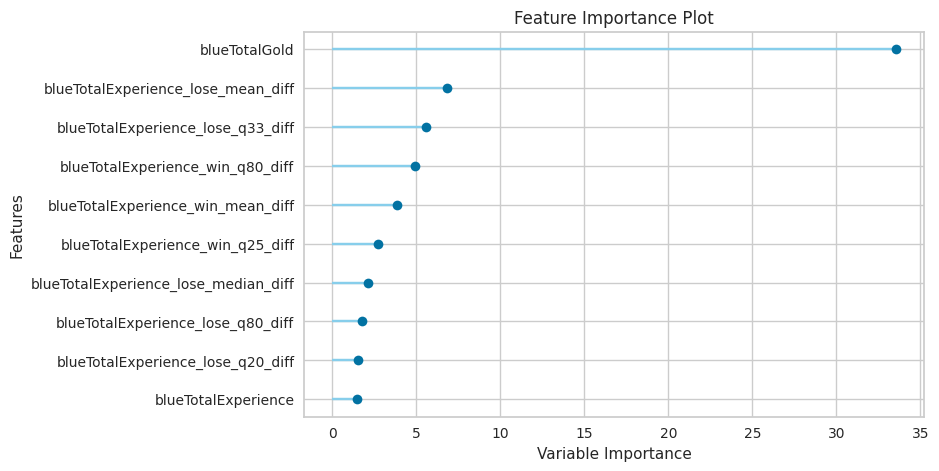

In [17]:
exp.plot_model(best, plot="feature")

In [18]:
exp.predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7942,0.8734,0.8068,0.7816,0.7940,0.5884,0.5887


,blueFirstBlood,blueKills,blueDeaths,blueDragons,blueTotalGold,blueTotalExperience,blueHerald,blueKills_win_mean_diff,blueKills_lose_mean_diff,blueDeaths_win_mean_diff,...,blueTotalExperience_blueDragons_mean,blueTotalExperience_blueDragons_max,blueTotalExperience_blueDragons_min,blueTotalExperience_blueDragons_median,blueTotalExperience_blueDragons_q25,blueTotalExperience_blueDragons_q75,blueTotalExperience_blueDragons_std,blueWins,prediction_label,prediction_score
4192,0,0,8,0,17409.0,17256.0,0,-6.930097,-6.930097,2.715302,...,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,0,0,0.9390
933,0,6,6,0,20619.0,17256.0,0,-0.930097,-0.930097,0.715302,...,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,0,0,0.6921
353,0,4,4,0,18117.0,18201.0,0,-2.930097,-2.930097,-1.284698,...,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,1,1,0.6868
3469,0,7,6,0,18117.0,18491.0,0,0.069903,0.069903,0.715302,...,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,1,1,0.7148
2755,0,5,6,0,17409.0,17256.0,0,-1.930097,-1.930097,0.715302,...,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,0,0,0.9151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,0,5,6,1,16961.0,18472.0,0,-1.930097,-1.930097,0.715302,...,18285.949219,20004.0,16650.0,18201.0,18021.0,18491.0,596.929260,0,1,0.6222
6017,0,6,10,0,20619.0,17256.0,1,-0.930097,-0.930097,4.715302,...,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,0,0,0.8639
4257,0,4,12,0,17409.0,17256.0,0,-2.930097,-2.930097,6.715302,...,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,0,0,0.9846
6028,1,9,5,1,19558.0,18201.0,0,2.069903,2.069903,-0.284698,...,18285.949219,20004.0,16650.0,18201.0,18021.0,18491.0,596.929260,1,1,0.5900


In [19]:
exp.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [20]:
tuned_model = exp.tune_model(
    best,
    search_library="optuna",
    choose_better=True,
    optimize="Accuracy",
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7982,0.8697,0.8188,0.7820,0.8000,0.5966,0.5973
1,0.7536,0.8336,0.8007,0.7270,0.7621,0.5077,0.5103
2,0.7875,0.8727,0.8333,0.7591,0.7945,0.5755,0.5782
3,0.7696,0.8658,0.7790,0.7597,0.7692,0.5394,0.5395
4,0.7696,0.8603,0.8327,0.7340,0.7802,0.5402,0.5450
5,0.7625,0.8588,0.8000,0.7383,0.7679,0.5255,0.5273
6,0.7429,0.8369,0.7345,0.7399,0.7372,0.4855,0.4855
7,0.7536,0.8354,0.8109,0.7217,0.7637,0.5081,0.5118
8,0.7607,0.8458,0.7964,0.7374,0.7657,0.5219,0.5236


[I 2024-01-21 05:59:00,653] Searching the best hyperparameters using 5600 samples...
[I 2024-01-21 06:01:46,527] Finished hyperparameter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [21]:
exp.predict_model(tuned_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7958,0.8737,0.8093,0.7828,0.7958,0.5918,0.5921


,blueFirstBlood,blueKills,blueDeaths,blueDragons,blueTotalGold,blueTotalExperience,blueHerald,blueKills_win_mean_diff,blueKills_lose_mean_diff,blueDeaths_win_mean_diff,...,blueTotalExperience_blueDragons_mean,blueTotalExperience_blueDragons_max,blueTotalExperience_blueDragons_min,blueTotalExperience_blueDragons_median,blueTotalExperience_blueDragons_q25,blueTotalExperience_blueDragons_q75,blueTotalExperience_blueDragons_std,blueWins,prediction_label,prediction_score
4192,0,0,8,0,17409.0,17256.0,0,-6.930097,-6.930097,2.715302,...,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,0,0,0.9400
933,0,6,6,0,20619.0,17256.0,0,-0.930097,-0.930097,0.715302,...,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,0,0,0.6865
353,0,4,4,0,18117.0,18201.0,0,-2.930097,-2.930097,-1.284698,...,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,1,1,0.6821
3469,0,7,6,0,18117.0,18491.0,0,0.069903,0.069903,0.715302,...,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,1,1,0.7170
2755,0,5,6,0,17409.0,17256.0,0,-1.930097,-1.930097,0.715302,...,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,0,0,0.9167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,0,5,6,1,16961.0,18472.0,0,-1.930097,-1.930097,0.715302,...,18285.949219,20004.0,16650.0,18201.0,18021.0,18491.0,596.929260,0,1,0.6223
6017,0,6,10,0,20619.0,17256.0,1,-0.930097,-0.930097,4.715302,...,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,0,0,0.8599
4257,0,4,12,0,17409.0,17256.0,0,-2.930097,-2.930097,6.715302,...,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,0,0,0.9842
6028,1,9,5,1,19558.0,18201.0,0,2.069903,2.069903,-0.284698,...,18285.949219,20004.0,16650.0,18201.0,18021.0,18491.0,596.929260,1,1,0.5859


In [22]:
final_model = exp.finalize_model(tuned_model)

In [23]:
unseen_predictions = exp.predict_model(
    final_model, data=test_df.select(pl.exclude("blueWins")).to_pandas()
)
unseen_predictions

,gameId,blueFirstBlood,blueKills,blueDeaths,blueDragons,blueTotalGold,blueTotalExperience,blueHerald,blueKills_win_mean_diff,blueKills_lose_mean_diff,...,blueTotalExperience_blueHerald_std,blueTotalExperience_blueDragons_mean,blueTotalExperience_blueDragons_max,blueTotalExperience_blueDragons_min,blueTotalExperience_blueDragons_median,blueTotalExperience_blueDragons_q25,blueTotalExperience_blueDragons_q75,blueTotalExperience_blueDragons_std,prediction_label,prediction_score
0,9,0,7,6,0,16961.0,18201.0,0,0.069903,0.069903,...,796.824707,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,1,0.5946
1,15,0,6,6,1,18513.0,18021.0,1,-0.930097,-0.930097,...,611.617737,18285.949219,20004.0,16650.0,18201.0,18021.0,18491.0,596.929260,1,0.7778
2,18,1,6,4,0,13475.0,17256.0,0,-0.930097,-0.930097,...,796.824707,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,0,0.5236
3,23,0,5,4,0,17409.0,17256.0,0,-1.930097,-1.930097,...,796.824707,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,0,0.8852
4,31,0,10,8,0,18117.0,18472.0,0,3.069903,3.069903,...,796.824707,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,1,0.5699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,0,17409.0,17256.0,0,-0.930097,-0.930097,...,796.824707,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,0,0.8368
1996,9980,0,4,4,0,17409.0,17256.0,0,-2.930097,-2.930097,...,796.824707,17820.650391,20101.0,16650.0,17256.0,17256.0,18201.0,807.047668,0,0.8880
1997,9983,1,6,3,1,18513.0,18201.0,0,-0.930097,-0.930097,...,796.824707,18285.949219,20004.0,16650.0,18201.0,18021.0,18491.0,596.929260,1,0.8939
1998,9996,1,10,9,1,18513.0,18201.0,0,3.069903,3.069903,...,796.824707,18285.949219,20004.0,16650.0,18201.0,18021.0,18491.0,596.929260,1,0.7698


In [24]:
unseen_predictions[["gameId", "prediction_label"]].rename(
    columns={"prediction_label": "blueWins"}
).to_csv("submit.csv", index=False, header=False)

In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb

kf = KFold(n_splits=5, shuffle=True, random_state=123)

In [26]:
def train_and_predict(params, callbacks=[]):
    models = []
    model_predicts = []
    valid_predicts = []

    X = train_df.select(pl.exclude(["gameId", "blueWins"])).to_numpy()
    Y = train_df.get_column("blueWins").to_numpy()
    for train_indices, valid_indices in kf.split(X):
        X_train, Y_train, X_valid, Y_valid = (
            X[train_indices],
            Y[train_indices],
            X[valid_indices],
            Y[valid_indices],
        )

        lgb_train = lgb.Dataset(X_train, Y_train)
        lgb_valid = lgb.Dataset(X_valid, Y_valid, reference=lgb_train)

        booster = lgb.train(
            params,
            train_set=lgb_train,
            valid_sets=[lgb_train, lgb_valid],
            num_boost_round=100000000,
            callbacks=[
                lgb.early_stopping(100, False, True),
                lgb.log_evaluation(100),
                *callbacks,
            ],
        )

        models.append(booster)

        model_predicts.append(booster.predict(X_valid))
        valid_predicts.append(Y_valid)

    return models, np.concatenate(model_predicts), np.concatenate(valid_predicts)

In [27]:
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "verbosity": -1,
    "random_state": 123,
    "learning_rate": 0.05,
    "device": "cuda",
}

_, predicts, valid = train_and_predict(params)
print("Accuracy", accuracy_score(valid, np.rint(predicts)))

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.793414	valid_1's auc: 0.767369
Early stopping, best iteration is:
[64]	training's auc: 0.890667	valid_1's auc: 0.856319
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.899352	valid_1's auc: 0.878691
[200]	training's auc: 0.914717	valid_1's auc: 0.88049
Early stopping, best iteration is:
[161]	training's auc: 0.910056	valid_1's auc: 0.880866
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.904334	valid_1's auc: 0.857239
[200]	training's auc: 0.91931	valid_1's auc: 0.855936
Early stopping, best iteration is:
[147]	training's auc: 0.912396	valid_1's auc: 0.857664
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.900292	valid_1's auc: 0.865369
Early stopping, best iteration is:
[44]	training's auc: 0.886179	valid_1's auc: 0.866551
Training until validation scores don't improve for 100 rounds
[100

In [28]:
import optuna

params_base = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "verbosity": -1,
    "random_state": 123,
    "learning_rate": 0.05,
    "device": "cuda",
    "extra_trees": True,
}


def objective(trial):
    params = {
        **params_base,
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    pruning_callback = optuna.integration.LightGBMPruningCallback(
        trial, "auc", "valid_1"
    )
    models, predicts, valid_y = train_and_predict(params, callbacks=[pruning_callback])
    accuracy = accuracy_score(valid_y, np.rint(predicts))
    return accuracy

In [29]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.866991	valid_1's auc: 0.842999
[200]	training's auc: 0.889196	valid_1's auc: 0.855283
[300]	training's auc: 0.895871	valid_1's auc: 0.857366
[400]	training's auc: 0.901244	valid_1's auc: 0.857007
Early stopping, best iteration is:
[316]	training's auc: 0.896985	valid_1's auc: 0.857811
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.873116	valid_1's auc: 0.868951
[200]	training's auc: 0.886356	valid_1's auc: 0.877082
[300]	training's auc: 0.893135	valid_1's auc: 0.87956
[400]	training's auc: 0.898321	valid_1's auc: 0.879835
[500]	training's auc: 0.901791	valid_1's auc: 0.880305
[600]	training's auc: 0.904739	valid_1's auc: 0.880985
[700]	training's auc: 0.907496	valid_1's auc: 0.881002
Early stopping, best iteration is:
[609]	training's auc: 0.904995	valid_1's auc: 0.881282
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.87595	

In [30]:
best_params = study.best_params
best_params

{'lambda_l1': 0.011546663996419845,
 'lambda_l2': 4.2290052251299e-05,
 'num_leaves': 213,
 'feature_fraction': 0.6729700038393581,
 'bagging_fraction': 0.9258891415545929,
 'bagging_freq': 4,
 'min_child_samples': 69}

In [31]:
from sklearn.model_selection import train_test_split

X = train_df.select(pl.exclude(["gameId", "blueWins"])).to_numpy()
Y = train_df.get_column("blueWins").to_numpy()

X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y, test_size=0.1, random_state=123, shuffle=True
)

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_valid = lgb.Dataset(X_valid, Y_valid, reference=lgb_train)

booster = lgb.train(
    params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    num_boost_round=100000000,
    callbacks=[
        lgb.early_stopping(100, False, True),
        lgb.log_evaluation(100),
    ],
)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.899046	valid_1's auc: 0.857022
[200]	training's auc: 0.915147	valid_1's auc: 0.854658
Early stopping, best iteration is:
[104]	training's auc: 0.900325	valid_1's auc: 0.857695


In [32]:
test_y_pred = booster.predict(
    test_df.select(pl.exclude(["gameId", "blueWins"])).to_numpy()
)

test_df.with_columns(pl.Series(name="blueWins", values=np.rint(test_y_pred))).select(
    pl.col(["gameId", "blueWins"]).cast(pl.Int64)
).write_csv("./submit.csv", include_header=False)